Following project is for IEEE-CIS classification competition.

In [1]:
import pandas as pd
test_identity = pd.read_csv("../input/ieee-fraud-detection/test_identity.csv")
test_transaction = pd.read_csv("../input/ieee-fraud-detection/test_transaction.csv")
train_identity = pd.read_csv("../input/ieee-fraud-detection/train_identity.csv")
train_transaction = pd.read_csv("../input/ieee-fraud-detection/train_transaction.csv")

Taking a look at the dataset, the size and first few entries.

In [2]:
train_transaction.shape

(590540, 394)

In [3]:
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The data description shows that the data has NaN values in it. The first task would be to identify the number of null entries each column has and on the basis of it, take a decision if the column has to be dropped or not.

Bar plot for the number of fradulent and non-fradulent transaction

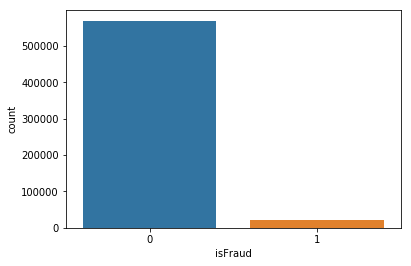

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(train_transaction['isFraud'])

What we see here is that the dataset is quite unbalanced. Unbalanced meaning the count of fraud and non-fraud transactions has a lot of difference. We need to take care of it while building the model.

**Analysis of TransactionDT**

The data given in TransactionDT is time and it spans over the year. Using this information we'll create a two new columns, day and month and check if a particular timeframe has a correlation with the occurance of fraud.

In [5]:
train_transaction['Month'] = (train_transaction['TransactionDT']//(3600*24)%12 + 1).astype(str)
train_transaction['Day'] = (train_transaction['TransactionDT']//(3600*24)%7 + 1).astype(str)

In [6]:
test_transaction['Month'] = (test_transaction['TransactionDT']//(3600*24)%12 + 1).astype(str)
test_transaction['Day'] = (test_transaction['TransactionDT']//(3600*24)%7 + 1).astype(str)

We'll try to identify if there is a relationship between the months and the fraud occurances and day and fraud occurances.

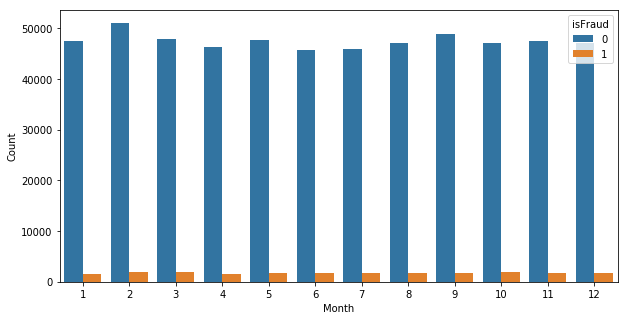

In [7]:
monthly_fraud = pd.DataFrame({'Count': train_transaction.groupby(['Month', 'isFraud'])['isFraud'].count()}).reset_index()
plt.figure(figsize=(10, 5))
sns.barplot(x='Month', y='Count', hue='isFraud', data=monthly_fraud, order=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'])

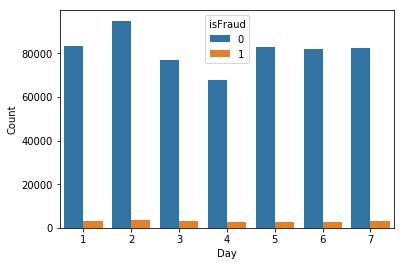

In [8]:
day_fraud = pd.DataFrame({'Count': train_transaction.groupby(['Day', 'isFraud'])['isFraud'].count()}).reset_index()
sns.barplot(x='Day', y='Count', hue='isFraud', data=day_fraud)

We couldn't infer any information from this but we can see that the day 4, the transactions are the lowest and the number of fraud cases still remain almost same.

**Analysis of Transaction Amount**

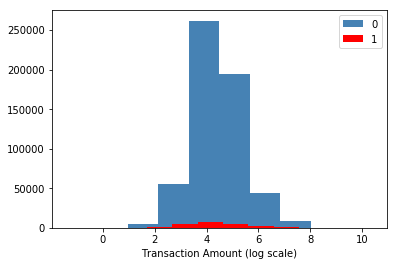

In [9]:
import numpy as np
amount_fraud = list(train_transaction.groupby('isFraud')['TransactionAmt'])
f, ax = plt.subplots(1, 1)
ax.hist(np.log(amount_fraud[0][1]), color='steelblue', label=0)
ax.hist(np.log(amount_fraud[1][1]), color='red', label=1)
ax.set_xlabel('Transaction Amount (log scale)')
ax.legend()
plt.show()

We can see that most of the fraud transaction occur a lower amount, around \$5000 - \$15000. Also taking the log transformation of the TransactionAmt column to make the distribution normal.

In [10]:
train_transaction['TransactionAmt'] = np.log(train_transaction['TransactionAmt'])

In [11]:
test_transaction['TransactionAmt'] = np.log(test_transaction['TransactionAmt'])

**Analysis of ProductCD**

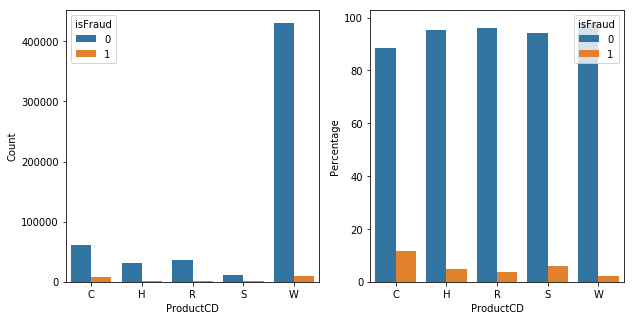

In [12]:
product_fraud = pd.DataFrame({'Count': train_transaction.groupby(['ProductCD', 'isFraud'])['ProductCD'].count()})
product_fraud['Percentage'] = product_fraud['Count']/product_fraud.groupby('ProductCD')['Count'].sum() *100
product_fraud = product_fraud.reset_index()
plt.figure(figsize=(10, 5))
plt.subplot(121)
sns.barplot(x='ProductCD', y='Count', hue='isFraud', data=product_fraud)
plt.subplot(122)
sns.barplot(x='ProductCD', y='Percentage', hue='isFraud', data=product_fraud)

It is clear from the analysis that the W is the most frequent ProductCD, but it has the least percentage of frauds. 'C' happens to have the most cases for frauds.

In [13]:
null_df = pd.DataFrame({'Null_Count':pd.isnull(train_transaction).sum()/train_transaction.shape[0]})
null_df = null_df.sort_values(by='Null_Count', ascending=False)
null_df[null_df['Null_Count'] > 0.5]

,Null_Count
dist2,0.936284
D7,0.934099
D13,0.895093
D14,0.894695
D12,0.890410
...,...
M5,0.593494
M7,0.586353
M8,0.586331
M9,0.586331


Almost half the columns of the dataset have more than 50% null values. Since there are a lot of variables which have majority as null values, it would be important to understand what the variables mean in the dataset. The column names starting with D and V are numerical columns and the column starting with M are boolean columns. We'll take a look at each category of columns and understand the NaN values in them.

In [14]:
card_columns = [col for col in train_transaction.columns if col.startswith('card')]
null_df.loc[card_columns, :].sort_values(by='Null_Count', ascending=False)

,Null_Count
card2,0.015127
card5,0.007212
card4,0.002670
card6,0.002660
card3,0.002650
card1,0.000000


'card4' and 'card6' are categorical columns. Plotting for getting further information.

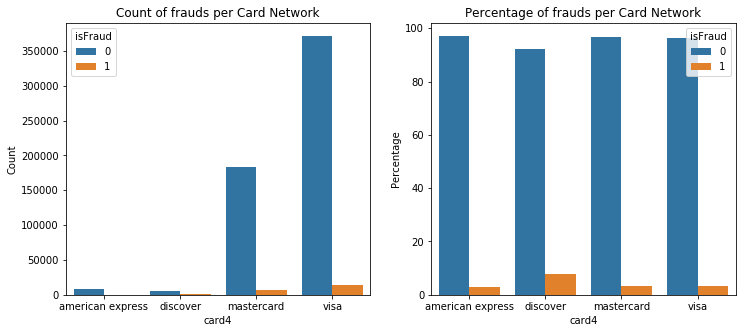

In [15]:
card4_fraud = pd.DataFrame({'Count': train_transaction.groupby(['card4', 'isFraud'])['card4'].count()})
card4_fraud['Percentage'] = card4_fraud['Count']/card4_fraud.groupby('card4')['Count'].sum() *100
card4_fraud = card4_fraud.reset_index()
plt.figure(figsize=(12, 5))
plt.subplot(121)
sns.barplot(x='card4', y='Count', hue='isFraud', data=card4_fraud)
plt.title('Count of frauds per Card Network')
plt.subplot(122)
plt.title('Percentage of frauds per Card Network')
sns.barplot(x='card4', y='Percentage', hue='isFraud', data=card4_fraud)

Visa has the most customers and discover has the least amount of customers. But considering the percentage of frauds for each network, discover comes out on top. Visa has the least percentage of frauds.

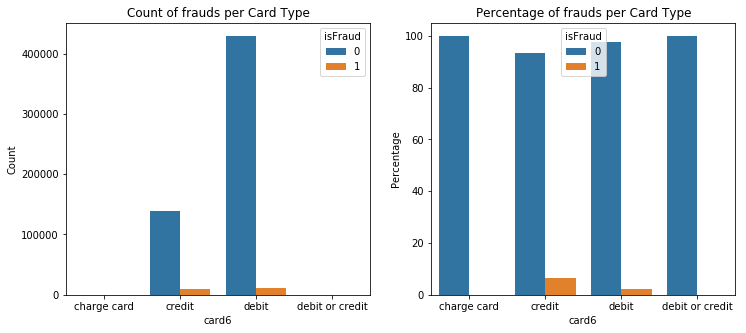

In [16]:
card6_fraud = pd.DataFrame({'Count': train_transaction.groupby(['card6', 'isFraud'])['card6'].count()})
card6_fraud['Percentage'] = card6_fraud['Count']/card6_fraud.groupby('card6')['Count'].sum() *100
card6_fraud = card6_fraud.reset_index()
plt.figure(figsize=(12, 5))
plt.subplot(121)
sns.barplot(x='card6', y='Count', hue='isFraud', data=card6_fraud)
plt.title('Count of frauds per Card Type')
plt.subplot(122)
plt.title('Percentage of frauds per Card Type')
sns.barplot(x='card6', y='Percentage', hue='isFraud', data=card6_fraud)

Credit card has the most percentage of frauds.

In [17]:
C_columns = [col for col in null_df.index.values if col.startswith('C')]
null_df.loc[C_columns, :].sort_values(by='Null_Count', ascending=False)

,Null_Count
C14,0.0
C1,0.0
C2,0.0
C3,0.0
C4,0.0
C5,0.0
C6,0.0
C7,0.0
C8,0.0
C9,0.0


No missing values in C columns

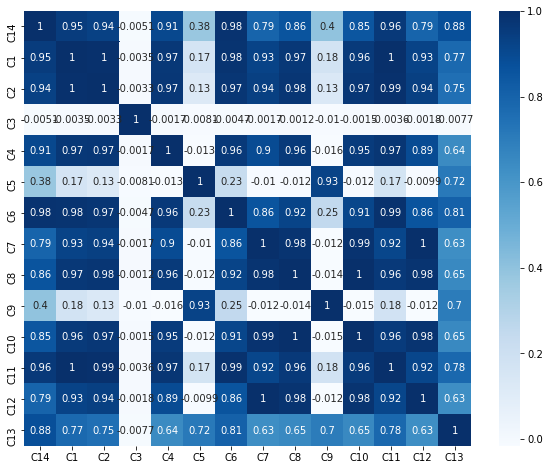

In [18]:
plt.figure(figsize=(10, 8))
corr = train_transaction.loc[:, C_columns].corr()
sns.heatmap(corr, cmap='Blues', annot=True)

As we can see from the heatmap, the columns are highly correlated among each other. We'll carefully select the columns which are not highly correlated. After careful examination, following columns are selected for further ecaluation C1, C3, C5, C13.

In [19]:
C_selected_columns = ['C1', 'C3', 'C5', 'C13']

In [20]:
dropped_columns = ['TransactionDT']
dropped_columns = dropped_columns + list(set(C_columns)^set(C_selected_columns))

In [21]:
D_columns = [col for col in null_df.index.values if col.startswith('D')]
null_df.loc[D_columns, :].sort_values(by='Null_Count', ascending=False)

,Null_Count
D7,0.934099
D13,0.895093
D14,0.894695
D12,0.890410
D6,0.876068
D8,0.873123
D9,0.873123
D5,0.524674
D2,0.475492
D11,0.472935


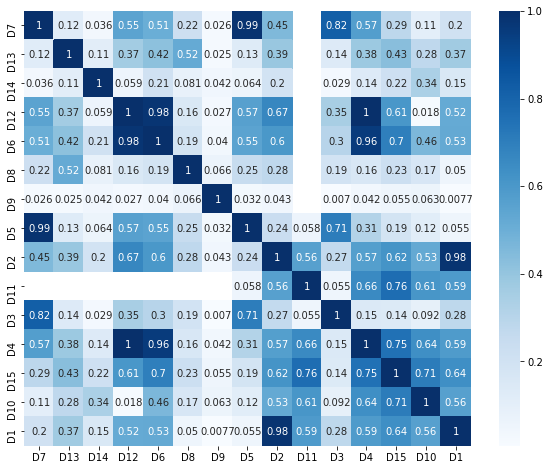

In [22]:
plt.figure(figsize=(10, 8))
corr = train_transaction.loc[:, D_columns].corr()
sns.heatmap(corr, cmap='Blues', annot=True)

Here too we can observe some of the columns have a very high correlation amongst each other. We'll filter out the columns such that there is less correlation amongst them. The columns are picked such that if they have correlation then the columns with the least amount of null values is selected.

In [23]:
D_selected_columns = ['D1', 'D3', 'D4', 'D5', 'D8', 'D9', 'D10', 'D11', 'D13', 'D14']

In [24]:
dropped_columns = dropped_columns + list(set(D_columns)^set(D_selected_columns))

In [25]:
M_columns = [col for col in null_df.index.values if col.startswith('M')]
null_df.loc[M_columns, :].sort_values(by='Null_Count', ascending=False)

,Null_Count
M5,0.593494
M7,0.586353
M8,0.586331
M9,0.586331
M4,0.476588
M1,0.459071
M3,0.459071
M2,0.459071
M6,0.286788
Month,0.000000


All the columns have null values. Lets examine the values in the columns so that they can be imputed.

In [26]:
train_transaction.loc[:, M_columns].describe()

,M5,M7,M8,M9,M4,M1,M3,M2,M6,Month
count,240058,244275,244288,244288,309096,319440,319440,319440,421180,590540
unique,2,2,2,2,3,2,2,2,2,12
top,F,F,F,T,M0,T,T,T,F,2
freq,132491,211374,155251,205656,196405,319415,251731,285468,227856,52933


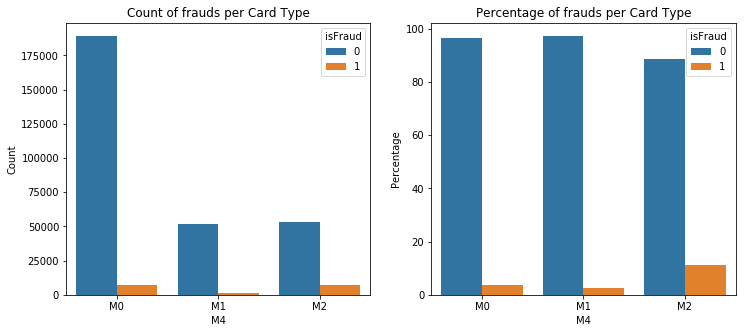

In [27]:
m4_fraud = pd.DataFrame({'Count': train_transaction.groupby(['M4', 'isFraud'])['M4'].count()})
m4_fraud['Percentage'] = m4_fraud['Count']/m4_fraud.groupby('M4')['Count'].sum() *100
m4_fraud = m4_fraud.reset_index()
plt.figure(figsize=(12, 5))
plt.subplot(121)
sns.barplot(x='M4', y='Count', hue='isFraud', data=m4_fraud)
plt.title('Count of frauds per Card Type')
plt.subplot(122)
plt.title('Percentage of frauds per Card Type')
sns.barplot(x='M4', y='Percentage', hue='isFraud', data=m4_fraud)

In [28]:
V_columns = [col for col in train_transaction.columns if col.startswith('V')]

In [29]:
train_transaction.loc[:, V_columns].describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
count,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,...,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.00000,82351.000000,82351.000000,82351.000000,82351.000000
mean,0.999945,1.045204,1.078075,0.846456,0.876991,1.045686,1.072870,1.027704,1.041529,0.463915,...,0.775874,721.741883,1375.783644,1014.622782,9.807015,59.16455,28.530903,55.352422,151.160542,100.700882
std,0.007390,0.240133,0.320890,0.440053,0.475902,0.239385,0.304779,0.186069,0.226339,0.521522,...,4.727971,6217.223583,11169.275702,7955.735482,243.861391,387.62948,274.576920,668.486833,1095.034387,814.946722
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,25.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
max,1.000000,8.000000,9.000000,6.000000,6.000000,9.000000,9.000000,8.000000,8.000000,4.000000,...,55.000000,160000.000000,160000.000000,160000.000000,55125.000000,55125.00000,55125.000000,104060.000000,104060.000000,104060.000000


The analysis of columns starting from V shows that even if the maximum value in the columns is the same, the descriptive statistics of the columns varies a lot. Hence we'll replace the NaN values in these columns with 0. Dropping the columns which are not required.

In [30]:
train_transaction.drop(dropped_columns, axis=1, inplace = True)

In [31]:
test_transaction.drop(dropped_columns, axis=1, inplace = True)

**Moving to the analysis of train_identity**

In [32]:
train_identity.dtypes

TransactionID      int64
id_01            float64
id_02            float64
id_03            float64
id_04            float64
id_05            float64
id_06            float64
id_07            float64
id_08            float64
id_09            float64
id_10            float64
id_11            float64
id_12             object
id_13            float64
id_14            float64
id_15             object
id_16             object
id_17            float64
id_18            float64
id_19            float64
id_20            float64
id_21            float64
id_22            float64
id_23             object
id_24            float64
id_25            float64
id_26            float64
id_27             object
id_28             object
id_29             object
id_30             object
id_31             object
id_32            float64
id_33             object
id_34             object
id_35             object
id_36             object
id_37             object
id_38             object
DeviceType        object


In [33]:
train_identity.head(5)

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


We'll first analyze the continuous variable in the dataset. Firstly, we'll select the continuous columns and check te percentage of ull values in them. Check if there is any correlation between the columns and remove the highly correlated columns and devise a way to impute the null values. 

In [34]:
identity_cont_columns = train_identity.select_dtypes(include=['int', 'float']).columns
train_identity.loc[:, identity_cont_columns].describe()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32
count,1.442330e+05,144233.000000,140872.000000,66324.000000,66324.000000,136865.000000,136865.000000,5155.000000,5155.000000,74926.000000,...,139369.000000,45113.000000,139318.000000,139261.000000,5159.000000,5169.000000,4747.000000,5132.000000,5163.000000,77586.000000
mean,3.236329e+06,-10.170502,174716.584708,0.060189,-0.058938,1.615585,-6.698710,13.285354,-38.600388,0.091023,...,189.451377,14.237337,353.128174,403.882666,368.269820,16.002708,12.800927,329.608924,149.070308,26.508597
std,1.788496e+05,14.347949,159651.816856,0.598231,0.701015,5.249856,16.491104,11.384207,26.084899,0.983842,...,30.375360,1.561302,141.095343,152.160327,198.847038,6.897665,2.372447,97.461089,32.101995,3.737502
min,2.987004e+06,-100.000000,1.000000,-13.000000,-28.000000,-72.000000,-100.000000,-46.000000,-100.000000,-36.000000,...,100.000000,10.000000,100.000000,100.000000,100.000000,10.000000,11.000000,100.000000,100.000000,0.000000
25%,3.077142e+06,-10.000000,67992.000000,0.000000,0.000000,0.000000,-6.000000,5.000000,-48.000000,0.000000,...,166.000000,13.000000,266.000000,256.000000,252.000000,14.000000,11.000000,321.000000,119.000000,24.000000
50%,3.198818e+06,-5.000000,125800.500000,0.000000,0.000000,0.000000,0.000000,14.000000,-34.000000,0.000000,...,166.000000,15.000000,341.000000,472.000000,252.000000,14.000000,11.000000,321.000000,149.000000,24.000000
75%,3.392923e+06,-5.000000,228749.000000,0.000000,0.000000,1.000000,0.000000,22.000000,-23.000000,0.000000,...,225.000000,15.000000,427.000000,533.000000,486.500000,14.000000,15.000000,371.000000,169.000000,32.000000
max,3.577534e+06,0.000000,999595.000000,10.000000,0.000000,52.000000,0.000000,61.000000,0.000000,25.000000,...,229.000000,29.000000,671.000000,661.000000,854.000000,44.000000,26.000000,548.000000,216.000000,32.000000


In [35]:
(pd.isnull(train_identity.loc[:, identity_cont_columns]).sum()/train_identity.shape[0]).sort_values(ascending=False)

id_24            0.967088
id_25            0.964419
id_07            0.964259
id_08            0.964259
id_21            0.964231
id_26            0.964204
id_22            0.964162
id_18            0.687221
id_03            0.540161
id_04            0.540161
id_09            0.480521
id_10            0.480521
id_32            0.462079
id_14            0.445037
id_13            0.117262
id_06            0.051084
id_05            0.051084
id_20            0.034472
id_19            0.034077
id_17            0.033723
id_02            0.023303
id_11            0.022568
id_01            0.000000
TransactionID    0.000000
dtype: float64

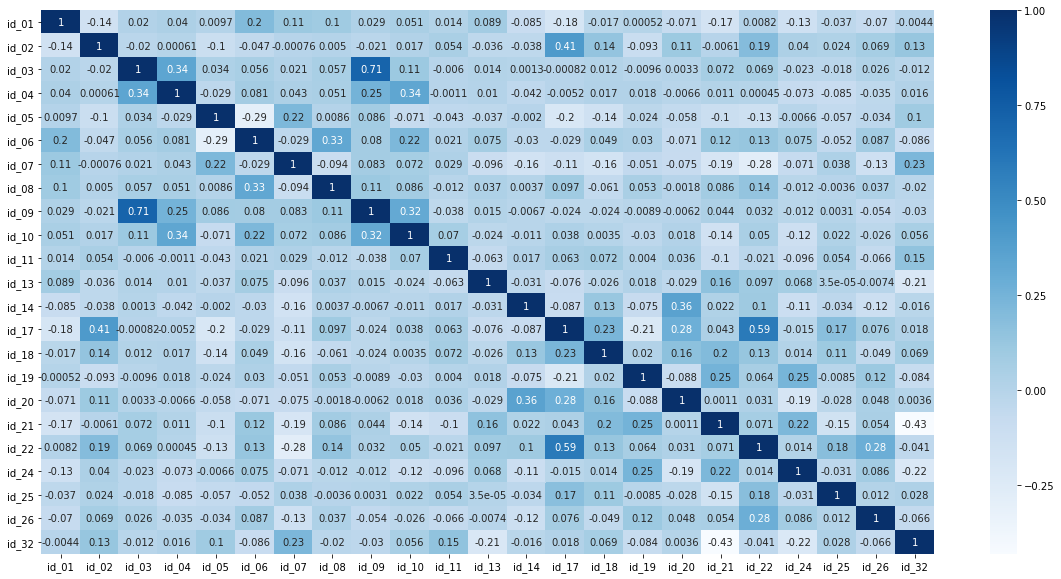

In [36]:
plt.figure(figsize=(20, 10))
corr = train_identity.loc[:, [col for col in identity_cont_columns if col.startswith('id')]].corr()
sns.heatmap(corr, cmap='Blues', annot=True)

As we can see, the amount of correlation in the columns is very less. Hence we'll keep all the columns from the selected columns. We'll impute the null values by filling the NaN values with 0.

Analysis of categorical variables of train_identity

In [37]:
identity_cat_columns = train_identity.select_dtypes(include=['object']).columns
train_identity.loc[:, identity_cat_columns].head()

,id_12,id_15,id_16,id_23,id_27,id_28,id_29,id_30,id_31,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,NotFound,New,NotFound,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,NotFound,New,NotFound,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,NotFound,Found,Found,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,F,F,T,T,desktop,Windows
3,NotFound,New,NotFound,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,F,F,T,T,desktop,NaN
4,NotFound,Found,Found,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [38]:
(pd.isnull(train_identity.loc[:, identity_cat_columns]).sum()/train_identity.shape[0]).sort_values(ascending=False)

id_23         0.964162
id_27         0.964162
id_33         0.491871
id_30         0.462224
id_34         0.460560
DeviceInfo    0.177262
id_16         0.103257
id_31         0.027393
DeviceType    0.023732
id_29         0.022568
id_28         0.022568
id_35         0.022519
id_36         0.022519
id_37         0.022519
id_38         0.022519
id_15         0.022519
id_12         0.000000
dtype: float64

'id_23' and 'id_27' have 96% null values. Hence we'll drop the columns. Also id_33 provides the dimension of the device which was used. Hence we'll drop that column too.

Column names in test dataset have `-` instead of `_`. Replacing the `-` by `_`

In [39]:
test_identity.columns = [col.replace('-', '_') for col in test_identity.columns]

In [40]:
train_identity.drop(['id_23','id_27','id_33'], inplace=True, axis=1)
test_identity.drop(['id_23','id_27','id_33'], inplace=True, axis=1)

We'll futher clean the data in order to reduce the number of distinct variables in the dataset.

In [41]:
train_identity.loc[train_identity['DeviceInfo'].str.match(r'SM|SAMSUNG|GT|SGH|Grand', na=False, case=False), 'DeviceInfo'] = 'SAMSUNG'
train_identity.loc[train_identity['DeviceInfo'].str.match(r'(LG|K10|^[RS]|(VS)|VK)', na=False, case=False), 'DeviceInfo'] = 'LG'
train_identity.loc[train_identity['DeviceInfo'].str.contains(r'HUAWEI|HONOR|DUK', na=False, case=False), 'DeviceInfo'] = 'HUAWEI'
train_identity.loc[train_identity['DeviceInfo'].str.match(r'lenovo|idea|yoga', na=False, case=False), 'DeviceInfo'] = 'LENOVO'
train_identity.loc[train_identity['DeviceInfo'].str.match(r'HTC|HT', na=False, case=False), 'DeviceInfo'] = 'HTC'
train_identity.loc[train_identity['DeviceInfo'].str.match(r'MI|XI|REDMI', na=False, case=False), 'DeviceInfo'] = 'XIOMI'
train_identity.loc[train_identity['DeviceInfo'].str.match(r'moto|xt|edison', na=False, case=False), 'DeviceInfo'] = 'MOTO'
train_identity.loc[train_identity['DeviceInfo'].str.match(r'zte|^z|blade|K88', na=False, case=False), 'DeviceInfo'] = 'ZTE'
train_identity.loc[train_identity['DeviceInfo'].str.match(r'windows|rv|win', na=False, case=False), 'DeviceInfo'] = 'WINDOWS NT'
train_identity.loc[train_identity['DeviceInfo'].str.match(r'^[F]|E2|E5|E66|^(H3)|^(LT)|^(D\d)', na=False, case=False), 'DeviceInfo'] = 'SONY'
train_identity.loc[train_identity['DeviceInfo'].str.match(r'^(80)|ONE TOUCH|^(50)|^(60)|^(90)|^(40)|alcatel', na=False, case=False), 'DeviceInfo'] = 'ALCATEL'
train_identity.loc[train_identity['DeviceInfo'].str.match(r'^(P00)|ASUS|ME', na=False, case=False), 'DeviceInfo'] = 'ASUS'
train_identity.loc[train_identity['DeviceInfo'].str.match(r'PIXEL|NEXUS', na=False, case=False), 'DeviceInfo'] = 'PIXEL'
train_identity.loc[train_identity['DeviceInfo'].str.match(r'TA', na=False, case=False), 'DeviceInfo'] = 'NOKIA'
train_identity.loc[train_identity['DeviceInfo'].str.match(r'^(KF)', na=False, case=False), 'DeviceInfo'] = 'AMAZON'
train_identity.loc[train_identity['DeviceInfo'].str.match(r'ilium', na=False, case=False), 'DeviceInfo'] = 'ILIUM'
train_identity.loc[train_identity['DeviceInfo'].str.match(r'E68|KY', na=False, case=False), 'DeviceInfo'] = 'KYOCERA'
train_identity.loc[train_identity['DeviceInfo'].str.match(r'Hisense', na=False, case=False), 'DeviceInfo'] = 'HISENSE'
train_identity.loc[train_identity['DeviceInfo'].str.match(r'verykool', na=False, case=False), 'DeviceInfo'] = 'VERYKOOL'
train_identity.loc[train_identity['DeviceInfo'].str.match(r'lava|iris|A97', na=False, case=False), 'DeviceInfo'] = 'LAVA'
train_identity.loc[train_identity['DeviceInfo'].str.match(r'X78|Max', na=False, case=False), 'DeviceInfo'] = 'MICROMAX'
train_identity.loc[train_identity['DeviceInfo'].str.match(r'aquaris', na=False, case=False), 'DeviceInfo'] = 'AQUARIS'

In [42]:
companies=['SAMSUNG', 'LG','HUAWEI', 'LENOVO','HTC','XIOMI', 'ZTE','WINDOWS NT', 'SONY','ALCATEL', 'ASUS','PIXEL','NOKIA','AMAZON', 'ILIUM','KYOCERA', 'HISENSE','VERYKOOL', 'LAVA', 'MICROMAX','AQUARIS']
train_identity.loc[~train_identity['DeviceInfo'].isin(companies), 'DeviceInfo']= 'Other'

In [43]:
train_identity['id_30'] = train_identity['id_30'].str.extract(r'^([\w]+)')
train_identity['id_31'] = train_identity['id_31'].str.extract(r'(^[\w\d]+)')

Doing the same for test_identity

In [44]:
test_identity.loc[test_identity['DeviceInfo'].str.match(r'(LG|K10|^[RS]|(VS)|VK)', na=False, case=False), 'DeviceInfo'] = 'LG'
test_identity.loc[test_identity['DeviceInfo'].str.contains(r'HUAWEI|HONOR|DUK', na=False, case=False), 'DeviceInfo'] = 'HUAWEI'
test_identity.loc[test_identity['DeviceInfo'].str.match(r'lenovo|idea|yoga', na=False, case=False), 'DeviceInfo'] = 'LENOVO'
test_identity.loc[test_identity['DeviceInfo'].str.match(r'HTC|HT', na=False, case=False), 'DeviceInfo'] = 'HTC'
test_identity.loc[test_identity['DeviceInfo'].str.match(r'MI|XI|REDMI', na=False, case=False), 'DeviceInfo'] = 'XIOMI'
test_identity.loc[test_identity['DeviceInfo'].str.match(r'moto|xt|edison', na=False, case=False), 'DeviceInfo'] = 'MOTO'
test_identity.loc[test_identity['DeviceInfo'].str.match(r'zte|^z|blade|K88', na=False, case=False), 'DeviceInfo'] = 'ZTE'
test_identity.loc[test_identity['DeviceInfo'].str.match(r'windows|rv|win', na=False, case=False), 'DeviceInfo'] = 'WINDOWS NT'
test_identity.loc[test_identity['DeviceInfo'].str.match(r'^[F]|E2|E5|E66|^(H3)|^(LT)|^(D\d)', na=False, case=False), 'DeviceInfo'] = 'SONY'
test_identity.loc[test_identity['DeviceInfo'].str.match(r'^(80)|ONE TOUCH|^(50)|^(60)|^(90)|^(40)|alcatel', na=False, case=False), 'DeviceInfo'] = 'ALCATEL'
test_identity.loc[test_identity['DeviceInfo'].str.match(r'^(P00)|ASUS|ME', na=False, case=False), 'DeviceInfo'] = 'ASUS'
test_identity.loc[test_identity['DeviceInfo'].str.match(r'PIXEL|NEXUS', na=False, case=False), 'DeviceInfo'] = 'PIXEL'
test_identity.loc[test_identity['DeviceInfo'].str.match(r'TA', na=False, case=False), 'DeviceInfo'] = 'NOKIA'
test_identity.loc[test_identity['DeviceInfo'].str.match(r'^(KF)', na=False, case=False), 'DeviceInfo'] = 'AMAZON'
test_identity.loc[test_identity['DeviceInfo'].str.match(r'ilium', na=False, case=False), 'DeviceInfo'] = 'ILIUM'
test_identity.loc[test_identity['DeviceInfo'].str.match(r'E68|KY', na=False, case=False), 'DeviceInfo'] = 'KYOCERA'
test_identity.loc[test_identity['DeviceInfo'].str.match(r'Hisense', na=False, case=False), 'DeviceInfo'] = 'HISENSE'
test_identity.loc[test_identity['DeviceInfo'].str.match(r'verykool', na=False, case=False), 'DeviceInfo'] = 'VERYKOOL'
test_identity.loc[test_identity['DeviceInfo'].str.match(r'lava|iris|A97', na=False, case=False), 'DeviceInfo'] = 'LAVA'
test_identity.loc[test_identity['DeviceInfo'].str.match(r'X78|Max', na=False, case=False), 'DeviceInfo'] = 'MICROMAX'
test_identity.loc[test_identity['DeviceInfo'].str.match(r'aquaris', na=False, case=False), 'DeviceInfo'] = 'AQUARIS'

In [45]:
companies=['SAMSUNG', 'LG','HUAWEI', 'LENOVO','HTC','XIOMI', 'ZTE','WINDOWS NT', 'SONY','ALCATEL', 'ASUS','PIXEL','NOKIA','AMAZON', 'ILIUM','KYOCERA', 'HISENSE','VERYKOOL', 'LAVA', 'MICROMAX','AQUARIS']
test_identity.loc[~test_identity['DeviceInfo'].isin(companies), 'DeviceInfo']= 'Other'

In [46]:
test_identity['id_30'] = test_identity['id_30'].str.extract(r'^([\w]+)')
test_identity['id_31'] = test_identity['id_31'].str.extract(r'(^[\w\d]+)')

Now the train_identity is mostly clean. We'll merge it with train_transaction now and imput the NaN values. We'll use the join type as outer because as mentioned in the problem statement, not all TransactionIDs have identity and vice versa.

In [47]:
train_transaction = pd.merge(train_transaction, train_identity, on='TransactionID', how='outer')

In [48]:
test_transaction = pd.merge(test_transaction, test_identity, on='TransactionID', how='outer')

In [49]:
train_transaction.drop(['TransactionID'], axis=1, inplace=True)

In [50]:
test_transaction.drop(['TransactionID'], axis=1, inplace=True)

**Imputing strategy for the columns**

**V-Columns**

In [51]:
for col in V_columns:
    train_transaction[col] = train_transaction[col].fillna(0)
    test_transaction[col] = test_transaction[col].fillna(0)

**D-Columns**

In [52]:
for col in D_selected_columns:
    train_transaction[col] = train_transaction[col].fillna(0)
    test_transaction[col] = test_transaction[col].fillna(0)

**C-Columns**

In [53]:
for col in C_selected_columns:
    test_transaction[col] = test_transaction[col].fillna(0)

**card-columns**

In [54]:
for col in [col for col in train_transaction.columns if col.startswith('card')]:
    train_transaction[col] = train_transaction[col].fillna(train_transaction[col].mode()[0])
    test_transaction[col] = test_transaction[col].fillna(test_transaction[col].mode()[0])

**addr-columns**

In [55]:
for col in [col for col in train_transaction.columns if col.startswith('addr')]:
    train_transaction[col] = train_transaction[col].fillna(train_transaction[col].mean())
    test_transaction[col] = test_transaction[col].fillna(test_transaction[col].mean())

**M-columns**

In [56]:
for col in M_columns:
    train_transaction[col] = train_transaction[col].fillna(train_transaction[col].mode()[0])
    test_transaction[col] = test_transaction[col].fillna(test_transaction[col].mode()[0])

**Dropping the pemail, dist1, dist2 columns**

In [57]:
train_transaction.drop(['dist1', 'dist2', 'R_emaildomain'], axis=1, inplace=True)
test_transaction.drop(['dist1', 'dist2', 'R_emaildomain'], axis=1, inplace=True)

**P_emaildomain**

In [58]:
train_transaction['P_emaildomain'] = train_transaction['P_emaildomain'].fillna(train_transaction['P_emaildomain'].mode()[0])
test_transaction['P_emaildomain'] = test_transaction['P_emaildomain'].fillna(test_transaction['P_emaildomain'].mode()[0])

**Identity categorical columns**

In [59]:
id_cat_columns = train_identity.select_dtypes(include='object').columns
for col in id_cat_columns:
    train_transaction[col] = train_transaction[col].fillna(train_transaction[col].mode()[0])
    test_transaction[col] = test_transaction[col].fillna(test_transaction[col].mode()[0])

**Identity continuous columns**

In [60]:
id_cont_columns = [col for col in train_identity.select_dtypes(include=['int','float']).columns if col.startswith('id')]
for col in id_cont_columns:
    train_transaction[col] = train_transaction[col].fillna(0)
    test_transaction[col] = test_transaction[col].fillna(0)

**Creating dummy variables for fitting a model**

In [61]:
y_train = train_transaction['isFraud']
train_transaction.drop('isFraud', axis=1, inplace=True)

The two dataframes, train_transaction and test_transaction are occupying around 3.5GB space in the memory. We'll run a function which will degrade the datatypes to a suitable datatypes, which in turn will reduce the memory consumption of the dataframes.

In [62]:
def reduce_memory(df):
    print('Size of the dataframe is: ', df.memory_usage().sum() / 1024**2)
    for col in df.select_dtypes(include=['int', 'float']).columns:
        mn = df[col].min()
        mx = df[col].max()
        if mn >= 0:
            if mx < 255:
                df[col] = df[col].astype(np.uint8)
            elif mx < 65535:
                df[col] = df[col].astype(np.uint16)
            elif mx < 4294967295:
                df[col] = df[col].astype(np.uint32)
            else:
                df[col] = df[col].astype(np.uint64)
        else:
            if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                df[col] = df[col].astype(np.int8)
            elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                df[col] = df[col].astype(np.int16)
            elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                df[col] = df[col].astype(np.int32)
            elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                df[col] = df[col].astype(np.int64)    
            else:
                df[col] = df[col].astype(np.float32)
    print('Memory usage after reduction: ', df.memory_usage().sum() / 1024**2)
    return df

In [63]:
train_transaction = reduce_memory(train_transaction)

Size of the dataframe is:  1856.2506103515625
Memory usage after reduction:  471.38402938842773


In [64]:
test_transaction = reduce_memory(test_transaction)

Size of the dataframe is:  1592.6871643066406
Memory usage after reduction:  402.52075481414795


In [65]:
train_transaction = pd.get_dummies(train_transaction)
test_transaction = pd.get_dummies(test_transaction)

The test_transaction dataframe has less number of labels and hence after getting the dummy variables, the number of features vary in the train_transaction and test_transaction. Hence we'll append the columns which are not present in the train_transaction.

In [66]:
test_add_columns = list(set(train_transaction.columns)^set(test_transaction.columns))

In [67]:
for col in test_add_columns:
    test_transaction[col] = 0

In [68]:
test_transaction = test_transaction.loc[:, train_transaction.columns]

**Building a model**

In [69]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

classifier = RandomForestClassifier(n_estimators=100, n_jobs=-1)
classifier.fit(train_transaction, y_train)
y_pred = classifier.predict(train_transaction)
confusion_matrix(y_train, y_pred)

array([[569877,      0],
       [    29,  20634]])

In [70]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train, y_pred)

0.9992982625949764

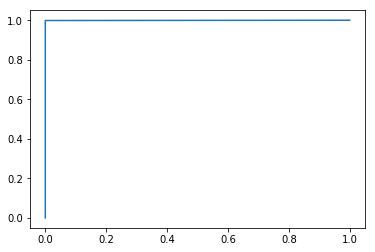

In [71]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train, y_pred)
plt.plot(fpr, tpr)

In [72]:
y_pred = classifier.predict_proba(test_transaction)

In [73]:
sample_submission = pd.read_csv("../input/ieee-fraud-detection/sample_submission.csv")

In [74]:
sample_submission['isFraud'] = y_pred[:, 1]

In [75]:
sample_submission.to_csv('submission.csv', index=False)

In [76]:
y = classifier.predict(test_transaction)

Number of frauds predicted by the classifier

In [77]:
sum(y == True)

7287

Number of frauds in the training dataset

In [78]:
sum(y_train == True)

20663